In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
# torch imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import splitfolders 
import cv2
import matplotlib
from matplotlib import pyplot as plt
import math 
import time 
import os
import copy
import random
import shutil

C:\Users\xie_k\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
class UTKDataset(Dataset):
    '''
        Inputs:
            dataFrame : Pandas dataFrame
            transform : The transform to apply to the dataset
    '''
    def __init__(self, dataFrame, transform=None):
        self.transform = transform
        
        data_holder = dataFrame.pixels.apply(lambda x: np.array(x.split(" "),dtype=float))
        arr = np.stack(data_holder)
        arr = arr / 255.0
        arr = arr.astype('float32')
        arr = np.array([arr, arr, arr])
        arr = arr.reshape(arr.shape[1], 48, 48, 3)
        # reshape into 48x48x1
        self.data = arr
        
#         self.age_label = np.array(dataFrame.age[:])      
        self.gender_label = np.array(dataFrame.gender[:])
#         self.eth_label = np.array(dataFrame.ethnicity[:])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data[index]
        data = self.transform(data)
        
#         labels = torch.tensor((self.age_label[index], self.gender_label[index], self.eth_label[index]))

#         labels = torch.tensor((self.age_label[index]))
        labels = torch.tensor((self.gender_label[index]))
   
        return data, labels

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# Hyper-parameters 
num_epochs = 10
batch_size = 128
learning_rate = 0.00001

In [35]:
dataFrame = pd.read_csv('age_gender.gz', compression='gzip')

# Construct age bins
# age_bins = [0,10,15,20,25,30,40,50,60,120]
# age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# dataFrame['bins'] = pd.cut(dataFrame.age, bins=age_bins, labels=age_labels)

# Split into training and testing
train_dataFrame, validation_test_dataFrame = train_test_split(dataFrame, test_size=0.2)
validation_dataFrame, test_dataFrame = train_test_split(validation_test_dataFrame, test_size=0.5)

# get the number of unique classes for each group
class_nums = {'age_num':len(dataFrame['age'].unique()), 'gen_num':len(dataFrame['gender'].unique())}

# Define train and test transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Construct the custom pytorch datasets
train_set = UTKDataset(train_dataFrame, transform=train_transform)
validation_set = UTKDataset(test_dataFrame, transform=validation_transform)
test_set = UTKDataset(test_dataFrame, transform=test_transform)

# Load the datasets into dataloaders
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Sanity Check
for data, lables in trainloader:
    print(f'Shape of training data: {data.shape}')
    print(f'Shape of lables: {lables.shape}')
    break



Shape of training data: torch.Size([128, 3, 48, 48])
Shape of lables: torch.Size([128])


In [36]:
dataloaders = {'train': trainloader, 'val': validationloader}
dataset_sizes = {'train': len(train_set), 'val': len(validation_set)}
dataset_sizes

{'train': 18964, 'val': 2371}

In [38]:
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[0].in_features
print(num_ftrs)

model_ft.classifier = nn.Sequential(
    nn.Linear(in_features=num_ftrs, out_features=1024),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=512),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=128),
    nn.Dropout(p=0.1),
    nn.ReLU(),
    
    nn.Linear(in_features=128, out_features=2)
)


model_ft = model_ft.to(device)

# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.6)

since = time.time()
lowest_loss = []
accuracy_list = []
val_acc_list= []
n_total_steps = len(trainloader)
for epoch in range(num_epochs):
    lowest_in_epoch = math.inf
    correct = 0
    total = 0
    best_label = []
    best_pred = []
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        
        labels = labels.to(device)
        labels = labels
        # Forward pass
        outputs = model_ft(images)
#         print(labels)
#         print(outputs)
#         print(f'Shape of training data: {outputs.shape}')
#         print(f'Shape of lables: {labels.shape}')
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print(total)
        correct += (pred.numpy() == labels.numpy()).sum()
#         print(correct)
        if loss.item() < lowest_in_epoch:
            lowest_in_epoch = loss.item()
            best_label = labels
            best_pred = outputs
    print(f'Epoch [{epoch+1}/{num_epochs}] and the best match:')
    print(best_label)
    print(best_pred)
    lowest_loss.append((epoch, lowest_in_epoch))
    accuracy = 100 * correct // total
    accuracy_list.append((epoch, accuracy))
    scheduler.step()
    
    val_correct = 0
    val_total = 0
    for images, labels in validationloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, val_pred = torch.max(outputs.data, 1)
        val_correct += (val_pred.numpy() == labels.numpy()).sum()
        val_total += labels.size(0)

    val_accuracy = 100 * val_correct / val_total
    val_acc_list.append((epoch, val_accuracy))
    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

25088
Epoch [1/10], Step [1/149], Loss: 0.6832
Epoch [1/10], Step [2/149], Loss: 0.6926
Epoch [1/10], Step [3/149], Loss: 0.6997
Epoch [1/10], Step [4/149], Loss: 0.6695
Epoch [1/10], Step [5/149], Loss: 0.7067
Epoch [1/10], Step [6/149], Loss: 0.7106
Epoch [1/10], Step [7/149], Loss: 0.7221
Epoch [1/10], Step [8/149], Loss: 0.6992
Epoch [1/10], Step [9/149], Loss: 0.6959
Epoch [1/10], Step [10/149], Loss: 0.6935
Epoch [1/10], Step [11/149], Loss: 0.6919
Epoch [1/10], Step [12/149], Loss: 0.6807
Epoch [1/10], Step [13/149], Loss: 0.6922
Epoch [1/10], Step [14/149], Loss: 0.6976
Epoch [1/10], Step [15/149], Loss: 0.7027
Epoch [1/10], Step [16/149], Loss: 0.6968
Epoch [1/10], Step [17/149], Loss: 0.6958
Epoch [1/10], Step [18/149], Loss: 0.6996
Epoch [1/10], Step [19/149], Loss: 0.6966
Epoch [1/10], Step [20/149], Loss: 0.6886
Epoch [1/10], Step [21/149], Loss: 0.6912
Epoch [1/10], Step [22/149], Loss: 0.6897
Epoch [1/10], Step [23/149], Loss: 0.6968
Epoch [1/10], Step [24/149], Loss: 0.

Epoch [2/10], Step [1/149], Loss: 0.6919
Epoch [2/10], Step [2/149], Loss: 0.6838
Epoch [2/10], Step [3/149], Loss: 0.6919
Epoch [2/10], Step [4/149], Loss: 0.6905
Epoch [2/10], Step [5/149], Loss: 0.6981
Epoch [2/10], Step [6/149], Loss: 0.6994
Epoch [2/10], Step [7/149], Loss: 0.6920
Epoch [2/10], Step [8/149], Loss: 0.7024
Epoch [2/10], Step [9/149], Loss: 0.6942
Epoch [2/10], Step [10/149], Loss: 0.6982
Epoch [2/10], Step [11/149], Loss: 0.6953
Epoch [2/10], Step [12/149], Loss: 0.6931
Epoch [2/10], Step [13/149], Loss: 0.6892
Epoch [2/10], Step [14/149], Loss: 0.6911
Epoch [2/10], Step [15/149], Loss: 0.6894
Epoch [2/10], Step [16/149], Loss: 0.6927
Epoch [2/10], Step [17/149], Loss: 0.6926
Epoch [2/10], Step [18/149], Loss: 0.6896
Epoch [2/10], Step [19/149], Loss: 0.6906
Epoch [2/10], Step [20/149], Loss: 0.6926
Epoch [2/10], Step [21/149], Loss: 0.6952
Epoch [2/10], Step [22/149], Loss: 0.6939
Epoch [2/10], Step [23/149], Loss: 0.6931
Epoch [2/10], Step [24/149], Loss: 0.6874
E

Epoch [3/10], Step [1/149], Loss: 0.6880
Epoch [3/10], Step [2/149], Loss: 0.6895
Epoch [3/10], Step [3/149], Loss: 0.6805
Epoch [3/10], Step [4/149], Loss: 0.6862
Epoch [3/10], Step [5/149], Loss: 0.6807
Epoch [3/10], Step [6/149], Loss: 0.6896
Epoch [3/10], Step [7/149], Loss: 0.6829
Epoch [3/10], Step [8/149], Loss: 0.6921
Epoch [3/10], Step [9/149], Loss: 0.6866
Epoch [3/10], Step [10/149], Loss: 0.6895
Epoch [3/10], Step [11/149], Loss: 0.6840
Epoch [3/10], Step [12/149], Loss: 0.6835
Epoch [3/10], Step [13/149], Loss: 0.6976
Epoch [3/10], Step [14/149], Loss: 0.6773
Epoch [3/10], Step [15/149], Loss: 0.6746
Epoch [3/10], Step [16/149], Loss: 0.6886
Epoch [3/10], Step [17/149], Loss: 0.6788
Epoch [3/10], Step [18/149], Loss: 0.7029
Epoch [3/10], Step [19/149], Loss: 0.6777
Epoch [3/10], Step [20/149], Loss: 0.6932
Epoch [3/10], Step [21/149], Loss: 0.6883
Epoch [3/10], Step [22/149], Loss: 0.6835
Epoch [3/10], Step [23/149], Loss: 0.6878
Epoch [3/10], Step [24/149], Loss: 0.6893
E

Epoch [4/10], Step [1/149], Loss: 0.6859
Epoch [4/10], Step [2/149], Loss: 0.6894
Epoch [4/10], Step [3/149], Loss: 0.6674
Epoch [4/10], Step [4/149], Loss: 0.6837
Epoch [4/10], Step [5/149], Loss: 0.6776
Epoch [4/10], Step [6/149], Loss: 0.6794
Epoch [4/10], Step [7/149], Loss: 0.6755
Epoch [4/10], Step [8/149], Loss: 0.6809
Epoch [4/10], Step [9/149], Loss: 0.6844
Epoch [4/10], Step [10/149], Loss: 0.6812
Epoch [4/10], Step [11/149], Loss: 0.6736
Epoch [4/10], Step [12/149], Loss: 0.6817
Epoch [4/10], Step [13/149], Loss: 0.6647
Epoch [4/10], Step [14/149], Loss: 0.6669
Epoch [4/10], Step [15/149], Loss: 0.6763
Epoch [4/10], Step [16/149], Loss: 0.6802
Epoch [4/10], Step [17/149], Loss: 0.6796
Epoch [4/10], Step [18/149], Loss: 0.6850
Epoch [4/10], Step [19/149], Loss: 0.7043
Epoch [4/10], Step [20/149], Loss: 0.6752
Epoch [4/10], Step [21/149], Loss: 0.6772
Epoch [4/10], Step [22/149], Loss: 0.6635
Epoch [4/10], Step [23/149], Loss: 0.6660
Epoch [4/10], Step [24/149], Loss: 0.6733
E

Epoch [5/10], Step [30/149], Loss: 0.6396
Epoch [5/10], Step [31/149], Loss: 0.6521
Epoch [5/10], Step [32/149], Loss: 0.6422
Epoch [5/10], Step [33/149], Loss: 0.6730
Epoch [5/10], Step [34/149], Loss: 0.6617
Epoch [5/10], Step [35/149], Loss: 0.6707
Epoch [5/10], Step [36/149], Loss: 0.6596
Epoch [5/10], Step [37/149], Loss: 0.6701
Epoch [5/10], Step [38/149], Loss: 0.6535
Epoch [5/10], Step [39/149], Loss: 0.6100
Epoch [5/10], Step [40/149], Loss: 0.6363
Epoch [5/10], Step [41/149], Loss: 0.6555
Epoch [5/10], Step [42/149], Loss: 0.6731
Epoch [5/10], Step [43/149], Loss: 0.6028
Epoch [5/10], Step [44/149], Loss: 0.6303
Epoch [5/10], Step [45/149], Loss: 0.6457
Epoch [5/10], Step [46/149], Loss: 0.6127
Epoch [5/10], Step [47/149], Loss: 0.6603
Epoch [5/10], Step [48/149], Loss: 0.6369
Epoch [5/10], Step [49/149], Loss: 0.6320
Epoch [5/10], Step [50/149], Loss: 0.6334
Epoch [5/10], Step [51/149], Loss: 0.6404
Epoch [5/10], Step [52/149], Loss: 0.6026
Epoch [5/10], Step [53/149], Loss:

Epoch [6/10], Step [1/149], Loss: 0.5891
Epoch [6/10], Step [2/149], Loss: 0.6137
Epoch [6/10], Step [3/149], Loss: 0.5982
Epoch [6/10], Step [4/149], Loss: 0.5763
Epoch [6/10], Step [5/149], Loss: 0.5255
Epoch [6/10], Step [6/149], Loss: 0.6321
Epoch [6/10], Step [7/149], Loss: 0.5763
Epoch [6/10], Step [8/149], Loss: 0.6014
Epoch [6/10], Step [9/149], Loss: 0.5695
Epoch [6/10], Step [10/149], Loss: 0.5344
Epoch [6/10], Step [11/149], Loss: 0.5394
Epoch [6/10], Step [12/149], Loss: 0.5195
Epoch [6/10], Step [13/149], Loss: 0.5906
Epoch [6/10], Step [14/149], Loss: 0.5490
Epoch [6/10], Step [15/149], Loss: 0.5404
Epoch [6/10], Step [16/149], Loss: 0.5562
Epoch [6/10], Step [17/149], Loss: 0.5358
Epoch [6/10], Step [18/149], Loss: 0.5279
Epoch [6/10], Step [19/149], Loss: 0.4992
Epoch [6/10], Step [20/149], Loss: 0.5312
Epoch [6/10], Step [21/149], Loss: 0.5227
Epoch [6/10], Step [22/149], Loss: 0.5113
Epoch [6/10], Step [23/149], Loss: 0.5359
Epoch [6/10], Step [24/149], Loss: 0.5310
E

Epoch [7/10], Step [1/149], Loss: 0.4738
Epoch [7/10], Step [2/149], Loss: 0.4703
Epoch [7/10], Step [3/149], Loss: 0.4557
Epoch [7/10], Step [4/149], Loss: 0.4750
Epoch [7/10], Step [5/149], Loss: 0.3891
Epoch [7/10], Step [6/149], Loss: 0.4421
Epoch [7/10], Step [7/149], Loss: 0.5022
Epoch [7/10], Step [8/149], Loss: 0.4054
Epoch [7/10], Step [9/149], Loss: 0.3835
Epoch [7/10], Step [10/149], Loss: 0.4547
Epoch [7/10], Step [11/149], Loss: 0.4045
Epoch [7/10], Step [12/149], Loss: 0.4256
Epoch [7/10], Step [13/149], Loss: 0.3961
Epoch [7/10], Step [14/149], Loss: 0.4229
Epoch [7/10], Step [15/149], Loss: 0.4258
Epoch [7/10], Step [16/149], Loss: 0.4225
Epoch [7/10], Step [17/149], Loss: 0.4194
Epoch [7/10], Step [18/149], Loss: 0.4319
Epoch [7/10], Step [19/149], Loss: 0.4380
Epoch [7/10], Step [20/149], Loss: 0.4915
Epoch [7/10], Step [21/149], Loss: 0.4460
Epoch [7/10], Step [22/149], Loss: 0.4645
Epoch [7/10], Step [23/149], Loss: 0.4914
Epoch [7/10], Step [24/149], Loss: 0.3864
E

Epoch [8/10], Step [30/149], Loss: 0.3139
Epoch [8/10], Step [31/149], Loss: 0.3537
Epoch [8/10], Step [32/149], Loss: 0.4044
Epoch [8/10], Step [33/149], Loss: 0.3441
Epoch [8/10], Step [34/149], Loss: 0.3669
Epoch [8/10], Step [35/149], Loss: 0.2865
Epoch [8/10], Step [36/149], Loss: 0.3530
Epoch [8/10], Step [37/149], Loss: 0.3563
Epoch [8/10], Step [38/149], Loss: 0.2875
Epoch [8/10], Step [39/149], Loss: 0.2960
Epoch [8/10], Step [40/149], Loss: 0.3222
Epoch [8/10], Step [41/149], Loss: 0.3701
Epoch [8/10], Step [42/149], Loss: 0.3194
Epoch [8/10], Step [43/149], Loss: 0.2879
Epoch [8/10], Step [44/149], Loss: 0.3620
Epoch [8/10], Step [45/149], Loss: 0.3753
Epoch [8/10], Step [46/149], Loss: 0.3239
Epoch [8/10], Step [47/149], Loss: 0.3420
Epoch [8/10], Step [48/149], Loss: 0.3444
Epoch [8/10], Step [49/149], Loss: 0.3135
Epoch [8/10], Step [50/149], Loss: 0.3395
Epoch [8/10], Step [51/149], Loss: 0.3710
Epoch [8/10], Step [52/149], Loss: 0.4477
Epoch [8/10], Step [53/149], Loss:

Epoch [9/10], Step [1/149], Loss: 0.3465
Epoch [9/10], Step [2/149], Loss: 0.2775
Epoch [9/10], Step [3/149], Loss: 0.2670
Epoch [9/10], Step [4/149], Loss: 0.2829
Epoch [9/10], Step [5/149], Loss: 0.2889
Epoch [9/10], Step [6/149], Loss: 0.1904
Epoch [9/10], Step [7/149], Loss: 0.2858
Epoch [9/10], Step [8/149], Loss: 0.2294
Epoch [9/10], Step [9/149], Loss: 0.3189
Epoch [9/10], Step [10/149], Loss: 0.2263
Epoch [9/10], Step [11/149], Loss: 0.2718
Epoch [9/10], Step [12/149], Loss: 0.2633
Epoch [9/10], Step [13/149], Loss: 0.2040
Epoch [9/10], Step [14/149], Loss: 0.3173
Epoch [9/10], Step [15/149], Loss: 0.3308
Epoch [9/10], Step [16/149], Loss: 0.3027
Epoch [9/10], Step [17/149], Loss: 0.2508
Epoch [9/10], Step [18/149], Loss: 0.2665
Epoch [9/10], Step [19/149], Loss: 0.2304
Epoch [9/10], Step [20/149], Loss: 0.2590
Epoch [9/10], Step [21/149], Loss: 0.2796
Epoch [9/10], Step [22/149], Loss: 0.2836
Epoch [9/10], Step [23/149], Loss: 0.1968
Epoch [9/10], Step [24/149], Loss: 0.2776
E

KeyboardInterrupt: 

In [50]:
lowest_loss, accuracy_list

([(0, 0.6694808006286621),
  (1, 0.6769370436668396),
  (2, 0.6681615710258484),
  (3, 0.6139336824417114),
  (4, 0.5770681500434875),
  (5, 0.4304210841655731),
  (6, 0.32195156812667847),
  (7, 0.259631484746933)],
 [(0, 51), (1, 52), (2, 53), (3, 57), (4, 63), (5, 72), (6, 78), (7, 84)])

In [39]:
correct = 0
total = 0
for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft(images)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
#         print(total)
    correct += (pred.numpy() == labels.numpy()).sum()

accuracy = 100 * correct / total
print(accuracy)
    

51.41290594685787


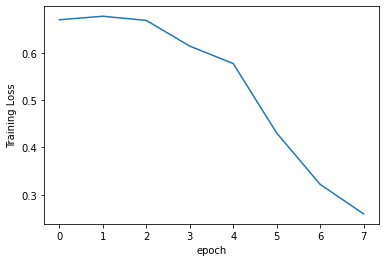

In [47]:
x_list = []
y_list = []
for i in range(8):
    x_list.append(i)
    y_list.append(lowest_loss[i][1])
plt.plot(x_list, y_list)
plt.xlabel("epoch")
plt.ylabel("Training Loss")
plt.show
plt.savefig("genderclassification-loss.png")

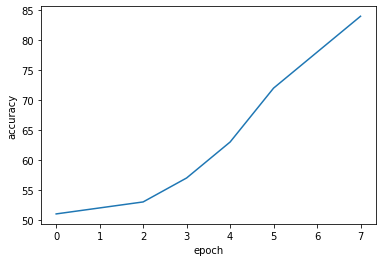

In [49]:
x_list = []
y_list = []
for i in range(8):
    x_list.append(i)
    y_list.append(accuracy_list[i][1])
plt.plot(x_list, y_list)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show
plt.savefig("genderclassification-accuracy.png")